# Kings County Housing Prices Bakeoff

In [1]:
# df_zip = pd.read_csv('zip_code_extra_data.csv')

### Import Packages

In [2]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# stats
from scipy import stats
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

## Step 1: Read in the Data

In [3]:
# Read in CSV and drop unneeded columns
df = pd.read_csv('kc_house_data_train.csv')
df = df.drop(columns=['Unnamed: 0', 'id'])

# View all columns
pd.set_option('display.max_columns', 25)

In [4]:
# FORMATTING DATE: adding year, month, and day columns
df['date'] = df['date'].str.slice(0, 8, 1)
df['year_sold'] = df['date'].str.slice(0, 4, 1)
df['month_sold'] = df['date'].str.slice(4, 6, 1)
df['day_sold'] = df['date'].str.slice(6, 8, 1)
df['date_sold'] = df['year_sold'] + '-' + df['month_sold'] + '-' + df['day_sold']

In [5]:
# Adjusting dtypes and dropping original data column
df['date_sold'] = pd.to_datetime(df['date_sold'])
df['year_sold'] = df['year_sold'].astype('int64')
df['month_sold'] = df['month_sold'].astype('int64')
df['day_sold'] = df['day_sold'].astype('int64')
df = df.drop(columns='date')

In [6]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold,date_sold
0,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,2014,10,6,2014-10-06
1,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,2014,8,21,2014-08-21
2,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,2014,8,15,2014-08-15
3,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,2015,3,31,2015-03-31
4,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,2014,7,14,2014-07-14


In [7]:
# replace 0 with yr_built so it doesnt think zero is a year -- last time the house was updated
df['yr_renovated'] = df['yr_renovated'].replace(0, df['yr_built'])

In [8]:
# updating incorrect value
df.at[8597,'bedrooms']= 3

## Step 2 + 3 : Exploratory Data Analysis & Clean up any issues (extreme values, etc.) with the data.
Become familiar with the data. Look to see if there are any extreme values.

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it.

In [9]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# df.hist(bins=50, figsize=(20,15))
# plt.show()

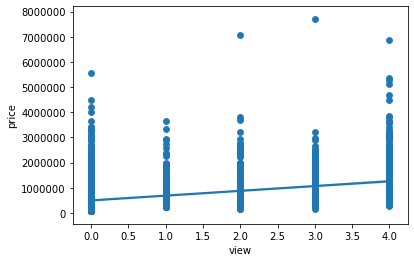

In [10]:
df.plot.scatter(x='view', y='price');
sns.regplot(data=df, x='view', y='price');

In [11]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold
price,1.000000,0.313775,0.524335,0.703540,0.086803,0.256985,0.275779,0.395485,0.036099,0.666215,0.607760,0.323312,0.056450,0.104812,-0.048958,0.302394,0.019327,0.585567,0.081423,-0.002334,-0.004350,-0.017157
bedrooms,0.313775,1.000000,0.524033,0.588536,0.030674,0.179908,-0.008668,0.082724,0.021376,0.366405,0.488420,0.307873,0.159936,0.168762,-0.152831,-0.003991,0.129593,0.401073,0.028038,-0.010211,0.002985,-0.011463
bathrooms,0.524335,0.524033,1.000000,0.755270,0.085470,0.497967,0.065848,0.188817,-0.122976,0.664191,0.686853,0.282700,0.507761,0.536815,-0.201527,0.023074,0.221308,0.568080,0.086499,-0.030045,0.012950,-0.000155
sqft_living,0.703540,0.588536,0.755270,1.000000,0.166810,0.357169,0.109738,0.283336,-0.061530,0.762929,0.876696,0.435529,0.319397,0.342839,-0.195893,0.052646,0.234453,0.755066,0.179570,-0.033606,0.017737,-0.009618
sqft_lot,0.086803,0.030674,0.085470,0.166810,1.000000,-0.002205,0.015356,0.073058,-0.013715,0.110320,0.180755,0.008065,0.054228,0.052918,-0.126590,-0.082029,0.226190,0.136959,0.701875,0.003141,-0.001722,0.004204
floors,0.256985,0.179908,0.497967,0.357169,-0.002205,1.000000,0.025132,0.025883,-0.259230,0.458984,0.528509,-0.247481,0.483657,0.498899,-0.060560,0.048227,0.128795,0.283933,-0.008170,-0.024641,0.019629,-0.000914
waterfront,0.275779,-0.008668,0.065848,0.109738,0.015356,0.025132,1.000000,0.407565,0.009608,0.092234,0.077162,0.083433,-0.021981,0.005262,0.034282,-0.013331,-0.042728,0.091090,0.026895,-0.000824,0.005685,0.012574
view,0.395485,0.082724,0.188817,0.283336,0.073058,0.025883,0.407565,1.000000,0.045060,0.249554,0.164747,0.279939,-0.049593,-0.020531,0.089475,0.003820,-0.077572,0.279999,0.073185,0.000701,-0.004189,0.013054
condition,0.036099,0.021376,-0.122976,-0.061530,-0.013715,-0.259230,0.009608,0.045060,1.000000,-0.142066,-0.157466,0.166923,-0.358921,-0.392758,0.007068,-0.009927,-0.109200,-0.094307,-0.007125,-0.044871,0.017099,-0.006111
grade,0.666215,0.366405,0.664191,0.762929,0.110320,0.458984,0.092234,0.249554,-0.142066,1.000000,0.758247,0.165003,0.448003,0.458830,-0.184946,0.116196,0.198369,0.715745,0.116062,-0.036560,0.015166,-0.009128


In [12]:
df.sqft_living.describe()

count    17290.000000
mean      2081.464604
std        920.018539
min        290.000000
25%       1430.000000
50%       1920.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

## Step 4: Generate new features that you think could be important.
After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

### Rennovation Features

In [13]:
# df[['yr_built', 'yr_renovated']]
df['was_renovated'] = (df['yr_renovated'] - df['yr_built'])
df.was_renovated.value_counts()

0      16564
43        18
32        17
63        16
37        16
       ...  
39         1
113        1
109        1
10         1
16         1
Name: was_renovated, Length: 103, dtype: int64

In [14]:
df['years_updated'] = (2020 - df['yr_renovated'])

### Distance from Top School Features

In [15]:
# import py file
import scraper1

# call function that scrapes school data
school_coordinates = scraper1.top_schools()
school_coordinates

,name,lat,long,ad
0,Cascadia Elementary School,47.695213,-122.337156,"1700 N 90th Street Seattle, WA 98115"
1,Decatur Elementary School,47.685413,-122.283672,"7711 43rd Ave Ne Seattle, WA 98115"
2,Stella Schola,47.671574,-122.160037,"13505 Ne 75th Street Redmond, WA 98052"
3,Tesla Stem High School,47.645720,-122.035450,"4301 228th Ave Ne Redmond, WA 98053"
4,International Community School,47.664105,-122.191210,"11133 Ne 65th St Kirkland, WA 98033"
5,Raisbeck Aviation High School,47.537357,-122.318409,"9229 East Marginal Way S Seattle, WA 98108"
6,Medina Elementary School,47.617379,-122.233757,"8001 Ne 8th St. Medina, WA 98039"
7,Northstar Middle School,47.655232,-122.195519,"10903 Ne 53rd St Kirkland, WA 98033"
8,Issaquah High School,47.522461,-122.028661,"700 2nd Ave Se Issaquah, WA 98027"
9,Sunrise Elementary School,47.649000,-122.112320,"14075 172 Av Ne Redmond, WA 98052"


In [19]:
# house distance to a top school
# now that it has null values not working
from geopy.distance import geodesic

def get_distance(lat, long):
    miles = []
    for i in range(school_coordinates.shape[0]):
        school = (school_coordinates.loc[i]['lat'], school_coordinates.loc[i]['long'])
        miles.append(geodesic((lat,long), school).miles)
    return min(miles)

# return sum(miles)/len(miles)

In [20]:
# this takes the longest time to run
for i in range(df.shape[0]):
    lat = df.loc[i]['lat']
    long = df.loc[i]['long']
    df.at[i, 'top_school_distance'] = get_distance(lat, long)
    

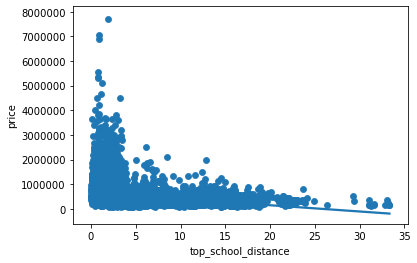

In [21]:
df.plot.scatter(x='top_school_distance', y='price');
sns.regplot(data=df, x='top_school_distance', y='price');

In [22]:
df['far_school'] = np.where(df['top_school_distance'] > df['top_school_distance'].quantile(q=.75), 1, 0)

In [23]:
df['q1'] = np.where((df['month_sold']==1) | (df['month_sold']==2) | (df['month_sold']==3), 1, 0)

In [24]:
df['q2'] = np.where((df['month_sold']==4) | (df['month_sold']==5) | (df['month_sold']==6), 1, 0)

In [25]:
df['q3'] = np.where((df['month_sold']==7) | (df['month_sold']==8) | (df['month_sold']==9), 1, 0)

In [26]:
df.groupby('month_sold')['price'].mean()

month_sold
1     515932.273990
2     508686.988889
3     537872.878342
4     561916.902993
5     553524.780602
6     561750.456361
7     545195.457694
8     539761.679052
9     526573.607349
10    540855.801072
11    528512.076256
12    526432.541880
Name: price, dtype: float64

In [27]:
pop_mean = df.price.mean()
pop_std = df.price.std()
print('POPULATION\nMean: ', pop_mean, '\nStandard Deviation:', pop_std)

q2_mean = df.groupby('q2')['price'].mean()[1]
q2_std = df.groupby('q2')['price'].std()[1]
q2_num = df.groupby('q2')['price'].count()[1]
print('\nQUARTER 2\nMean: ', q2_mean, '\nStandard Deviation:', q2_std)

not_q2_mean = df.groupby('q2')['price'].mean()[0]
not_q2_std = df.groupby('q2')['price'].std()[0]
not_q2_num = df.groupby('q2')['price'].count()[0]
print('\nQUARTER 1,3, AND 4\nMean: ', not_q2_mean, '\nStandard Deviation:', not_q2_std)

POPULATION
Mean:  540739.5486408329 
Standard Deviation: 373318.9787492793

QUARTER 2
Mean:  558913.8413855971 
Standard Deviation: 384954.0430415352

QUARTER 1,3, AND 4
Mean:  532295.1610334604 
Standard Deviation: 367498.58963784477


In [28]:
# Testing for the difference of two means

# laying out the equation
numerator = ((q2_mean - not_q2_mean) - 0)
denominator = (((q2_std**2)/q2_num)+((not_q2_std**2)/not_q2_num))**.5
# denominator = (((q2_std**2)/q2_num)+((not_q2_std**2)/not_q2_num))**.5

# calculating the t score
t = numerator/denominator

# calculate p-value from the t score
p_value = stats.t.sf(abs(t), df=(q2_num + not_q2_num - 2))

In [29]:
print('𝛼 = 0.05\nt-value: ', t, '\np-value: ', "%.15f" % p_value)

𝛼 = 0.05
t-value:  4.292344127490549 
p-value:  0.000008887944830


#### For this statistical test, the p-value is less than our alpha .05 meaning it is extremely unlikey to collect this sample data if the spending from both populations are equal to one another. Therefore, we can reject the null hypothesis.

<br>

In [30]:
#  create a test --- does quarter two perform better than the rest of the year

In [31]:
df['q4'] = np.where((df['month_sold']==10) | (df['month_sold']==11) | (df['month_sold']==12), 1, 0)

In [32]:
df.groupby('q4')['price'].mean()

q4
0    543016.408743
1    532702.834949
Name: price, dtype: float64

In [33]:
df['basement'] = np.where(df['sqft_basement']==0, 0, 1)

In [34]:
df.bedrooms.value_counts()

3     7865
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
Name: bedrooms, dtype: int64

In [35]:
df.bathrooms.value_counts()

2.50    4322
1.00    3100
1.75    2431
2.25    1666
2.00    1549
1.50    1168
2.75     896
3.00     592
3.50     591
3.25     455
3.75     135
4.00     107
4.50      76
4.25      64
0.75      52
5.00      17
4.75      16
5.25      11
0.00       8
5.50       7
1.25       6
6.00       6
5.75       3
0.50       3
8.00       2
6.75       2
6.25       2
7.50       1
6.50       1
7.75       1
Name: bathrooms, dtype: int64

In [36]:
df[df['bathrooms'] == 0.75]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,...,month_sold,day_sold,date_sold,was_renovated,years_updated,top_school_distance,far_school,q1,q2,q3,q4,basement
350,180250.0,2,0.75,900,9600,1.0,0,0,3,6,900,0,...,11,23,2014-11-23,0,79,5.403213,0,0,0,0,1,0
543,190000.0,1,0.75,930,29258,1.0,0,0,3,6,930,0,...,6,25,2014-06-25,0,79,3.366960,0,0,1,0,0,0
1122,204950.0,2,0.75,1130,11429,1.0,0,0,3,7,1130,0,...,8,26,2014-08-26,0,64,6.072968,0,0,0,1,0,0
1310,230000.0,2,0.75,900,3527,1.0,0,0,3,6,900,0,...,3,4,2015-03-04,0,81,2.169616,0,1,0,0,0,0
1379,124000.0,1,0.75,840,7203,1.5,0,0,3,6,840,0,...,10,3,2014-10-03,0,71,4.343576,0,0,0,0,1,0
1381,202000.0,1,0.75,590,5650,1.0,0,0,3,6,590,0,...,7,14,2014-07-14,0,76,2.036614,0,0,0,1,0,0
1438,100000.0,2,0.75,660,5240,1.0,0,0,4,4,660,0,...,7,3,2014-07-03,0,108,9.957319,1,0,0,1,0,0
1487,520000.0,4,0.75,1960,8277,1.0,1,4,4,7,1320,640,...,12,23,2014-12-23,63,34,11.924890,1,0,0,0,1,1
1540,385000.0,3,0.75,1330,7020,1.0,0,0,5,7,1330,0,...,10,23,2014-10-23,0,96,1.057062,0,0,0,0,1,0
1622,230000.0,3,0.75,1040,15000,1.0,0,0,3,6,1040,0,...,7,28,2014-07-28,0,79,3.291439,0,0,0,1,0,0


## Step 5: Train-Test Split
If you plan on doing any scaling of your data, make sure it is done at the appropriate time.

In [37]:
# added different features to mutiple linear regression and seeing how it affects the r-squared value

In [ ]:
bedrooms
bathrooms
basement
top_school_distance
sqft_living
grade
waterfront
view
yr_built
yr_renovated
sqft_living15
lat
floors

In [49]:
test_model = ols(formula='price~bedrooms+bathrooms+lat+basement+top_school_distance+sqft_living+grade+waterfront+view+yr_built+yr_renovated+sqft_living15', data=df).fit()
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     3084.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:56:23   Log-Likelihood:            -2.3599e+05
No. Observations:               17290   AIC:                         4.720e+05
Df Residuals:                   17276   BIC:                         4.721e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -6.046e+06   9.25e+05     -6.533      0.000   -7.86e+06   -4.23e+06
bedrooms            -3.742e+04   2206.393    -16.961      0.000   -4.17e+04   -3.31e+04
bathrooms            4.789e+04   3728.343     12.845      0.000    4.06e+04    5.52e+04
lat                  2.327e+05   1.91e+04     12.177      0.000    1.95e+05     2.7e+05
basement            -2.415e+04   3743.048     -6.453      0.000   -3.15e+04   -1.68e+04
top_school_distance -1.162e+04    535.409    -21.707      0.000   -1.27e+04   -1.06e+04
floors              -2468.4246   3865.511     -0.639      0.523      -1e+04    5108.368
sqft_living           179.8009      3.816     47.124      0.000     172.322     187.280
grade                9.788e+04   2415.548     40.521      0.000    9.31e+04    1.03e+05
waterfront           5.966e+05   1.93e+04     30.976      0.000    5.59e+05    6.34e+05
view                 5.079e+04   2368.098     21.446      0.000    4.61e+04    5.54e+04
yr_built            -3099.6582    131.649    -23.545      0.000   -3357.703   -2841.614
yr_renovated          277.9695    135.267      2.055      0.040      12.833     543.106
sqft_living15          15.1554      3.794      3.995      0.000       7.719      22.592
==============================================================================
Omnibus:                    15652.366   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1813221.236
Skew:                           3.916   Prob(JB):                         0.00
Kurtosis:                      52.554   Cond. No.                     2.43e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
# STRATIFY YOUR SPLIT
# sqft_living has the highest correlation break into quartiles

X = df[['bedrooms', 'bathrooms', 'lat', 'sqft_living', 'basement', 'top_school_distance', 'grade', 'waterfront', 'view', 'yr_built', 'yr_renovated', 'sqft_living15']] #predictors as x
y = df['price'] # target as y

X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

# Instantiate MinMaxScaler object
# lots of different ways to scale our data
minmax = MinMaxScaler()

# # Fit and Transform the training data.
X_train_transformed = minmax.fit_transform(X_train)

# # ONLY TRANSFORM the test data.
# #------- NEVER fit
X_test_transformed = minmax.transform(X_test)

# # Instantiate the Linear Regression Object.
model = LinearRegression()

# # Fit the model to the transformed X_train, and the y_train.
model.fit(X_train_transformed, y_train)

# # Score the model based on the transformed X_test and the y_test.
model.score(X_test_transformed, y_test)

0.7034620467206043

In [55]:
y_train_pred = model.predict(X_train_transformed)

In [56]:
train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Mean Absolute Error:', train_mae )
print('Mean Squared Error:',  train_mse)
print('Root Mean Squared Error:' , train_rmse)

Mean Absolute Error: 126320.43994956433
Mean Squared Error: 42604656803.87935
Root Mean Squared Error: 206408.95524148014


In [57]:
price_std = df['price'].std()

print('Z-Score of Mean Absolute Error:', train_mae/price_std )
print('Z-Score of Root Mean Squared Error:' , train_rmse/price_std)

Z-Score of Mean Absolute Error: 0.3383713315962997
Z-Score of Root Mean Squared Error: 0.5529023890856195


In [59]:
# log on price

In [60]:
# STRATIFY YOUR SPLIT
# sqft_living has the highest correlation break into quartiles

X = df[['bedrooms', 'bathrooms', 'lat', 'sqft_living', 'basement', 'top_school_distance', 'grade', 'waterfront', 'view', 'yr_built', 'yr_renovated', 'sqft_living15']] #predictors as x
y = np.log(df['price']) # target as y

X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

# Instantiate MinMaxScaler object
# lots of different ways to scale our data
minmax = MinMaxScaler()

# # Fit and Transform the training data.
X_train_transformed = minmax.fit_transform(X_train)

# # ONLY TRANSFORM the test data.
# #------- NEVER fit
X_test_transformed = minmax.transform(X_test)

# # Instantiate the Linear Regression Object.
model = LinearRegression()

# # Fit the model to the transformed X_train, and the y_train.
model.fit(X_train_transformed, y_train)

# # Score the model based on the transformed X_test and the y_test.
model.score(X_test_transformed, y_test)

0.7827070247008978

In [61]:
y_train_pred = model.predict(X_train_transformed)

In [65]:
y_train_pred = y_train_pred ** 10

In [66]:
train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Mean Absolute Error:', train_mae )
print('Mean Squared Error:',  train_mse)
print('Root Mean Squared Error:' , train_rmse)

Mean Absolute Error: 152427514858.47296
Mean Squared Error: 2.7560915719333377e+22
Root Mean Squared Error: 166014805723.26486


In [67]:
price_std = df['price'].std()

print('Z-Score of Mean Absolute Error:', train_mae/price_std )
print('Z-Score of Root Mean Squared Error:' , train_rmse/price_std)

Z-Score of Mean Absolute Error: 408303.6854144058
Z-Score of Root Mean Squared Error: 444699.6139319246


In [58]:
# STRATIFIED SPLIT

### 4.1) Identify a categorical variable in the data set and create dummy columns.

### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

### 4.3) There are columns for when the house was built and when it was renovated. How could you use these columns to create a new column?

### Non-linear transformations
### 4.4) Create a polynomial feature for two of your continuous variables.

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

### 5.1) Perform a train-test split of the data.

### 5.2) Fit your scaler to training the data.

### 5.3) Transform the testing set with the scaler.

### 5.4) Fit the model to the training data.

### 5.5) Use the model to predict on the training set and the test set.

### 5.6) Evaluate the training and test predictions using RMSE.

### 5.7) Determine if your model is overfit.

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.1) Utilize a filter method to identify some features to remove from the model.

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

## Step 7: Evaluate your different models in order to determine the best model overall.

## Step 8: Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/